# Agent's individual performance

1. [Create train.csv et test.csv](#first-bullet)  <br>
2. [Create feature_extractor.py](#second-bullet)  <br>
3. [Create classifier.py](#third-bullet)  <br>
4. [Test Locally](#fourth-bullet)  <br>
5. [Test with Ramp](#fifth-bullet)  <br>

## Introduction <a class="anchor" id="fst-bullet"></a> 

In this part, we try to answer the question why some agent performs better than others. 

From a business point of view this is a rather important question as the assurance company would like to understand how they can improve agent performance. If some agents can have a higher percentage of active portfolio for the years in question than other agents, the company should try to research the given profil for future recruitments and coach already existing employees by better performing ones. 

Ideally, we would request additional data relating to agents, such as the years of experience, revenue generated by the agent. Here we do not have these information, however we have additional data regarding the clientele of each agent and the type of contracts they sell. 

Also, we use a created score (KPI) to capture agent performance, in order to consider the percentage of active portfolio and the total number of active contracts. 

In other models we focus on the reasons existing clients leave, therefore we could use the agent's percentage of active portfolio as a measure to classify better and poorer performing agents. However, this is an imperfect indicator of agent performance for two reasons: 
- firstly agent performance might be poor due to the clientele (this is one thing we investigate in what follows) 
- furthermore, the percentage of active portfolio might not be a good proxy for the agent performance as those agents who have 2 portfolios (with only 1 active) have the same score as another agent having 200 portfolios with 100 contracts active, although clearly, they do not provide the same revenue to the assurance company. 

Therefore, we consider the following KPI for agent performance : 
$$ agent \ score = \frac{1}{2} \Big( \frac{active \ contracts }{agent's \ total \ contracts} \ + \frac{agent's \ total \ contracts}{total \ contracts } \Big)$$


Finally instead of trying to predict the agent's score, we wish to predict whether the agent has a higher (0) or lower (1) score than the median agent score (we will refer to this variable as 'Better').

First we start with some stats and visualisation, then we try to show the main reasons why some agents have more success than others. 

In [1]:
import csv
import pandas as pd
import problem
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split

## Vizualization <a class="anchor" id="seco-bullet"></a> 

First we create a dataframe by adding all variables for the given agent: 
   - average of clientele (such as sex, social status, income) 
   - number of active and total contracts per agent 
   - agent caracteristics such as age
   - average contract caracteristics that the agent assures. 
   
Therefore we create a dummy variable, 'Better', representing whether the agent performs better (1) or worse (0) than the median agent. 

In [2]:
data = pd.read_csv('./data/data.csv') 
agent_data = problem.create_df_for_agent_analysis(data)
agent_data.to_csv("./data/agent_data.csv", index=False)
agent_data.head()

,agent_id,sum_assured,policy_premium,nb_riders,rider_premium,customer_marital_cd,customer_age,customer_social_group,customer_income,customer_additional_products,...,customer_origin_new,customer_gender_F,customer_gender_M,agent_status_inactive,customer_income_median,total_portfolio,percent_of_active_portfolio,percent_of_portfolio,Score,Better
0,AG_03198874,1.252000e+06,1550.000000,1.000000,1100.000000,1.000000,45.000000,6.000000,75000.000000,1.000000,...,1.000000,1.000000,0.000000,0.0,75000.0,150.0,0.593333,0.000308,0.296821,1
2,AG_05276714,1.216000e+06,1850.000000,2.000000,1450.000000,1.000000,42.500000,4.000000,75000.000000,1.500000,...,0.500000,0.000000,1.000000,0.0,75000.0,172.0,0.540698,0.000353,0.270525,0
4,AG_04302485,1.305756e+06,2231.707317,2.097561,1702.439024,1.780488,40.975610,3.609756,89634.146341,2.341463,...,0.829268,0.536585,0.463415,0.0,80000.0,231.0,0.761905,0.000474,0.381190,1
45,AG_04873767,1.241714e+06,1957.142857,2.000000,1357.142857,1.142857,40.714286,5.000000,105714.285714,2.142857,...,1.000000,0.142857,0.857143,0.0,70000.0,159.0,0.622642,0.000327,0.311484,1
52,AG_07944835,1.415000e+06,1950.000000,2.125000,1200.000000,2.000000,41.250000,3.625000,78750.000000,3.125000,...,0.500000,0.375000,0.625000,0.0,67500.0,467.0,0.513919,0.000959,0.257439,0


Next, let's plot the distribution of the percentage of agents' active contract and score as they serve as a proxy for agents performance. 

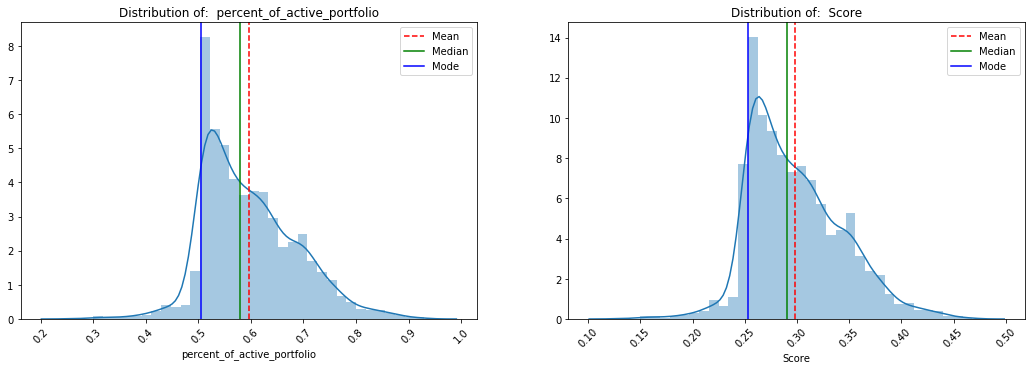

In [3]:
list_to_plot = ['percent_of_active_portfolio', 'Score']

problem.plot_dist_with_mean(agent_data, list_to_plot)

We see that the median agent has around 50% active assurances but that some agent has much higher percentage of active contracts. The mean agent score is 0.25, while the median is 0.3 (we will compare agent performance to this value).

Next we wish to visualize the distribution of each variable according to agent performance, so whether the agent has higher or lower percentage of active contracts than the median. 

##### Visualize the clientele by agent performance 

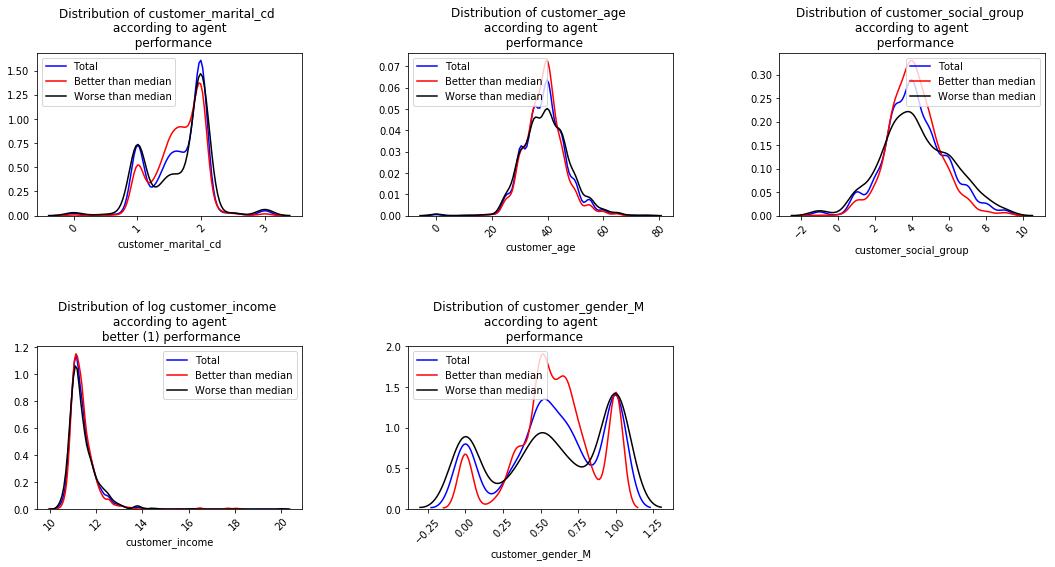

In [4]:
cols_plot = ['customer_marital_cd', 'customer_age', 'customer_social_group', 'customer_income', 'customer_gender_M']
problem.plot_distributions(agent_data, cols_plot)

We see that agents who perform better or worse than the median agent have a similar clientele considering the client's marital status, age, social group and sex. However, (and surprisingly), better performing agents clientele seems to have a lower income than worse performing agents' clients. To see this clearly, we plot the average income by agent performance: 

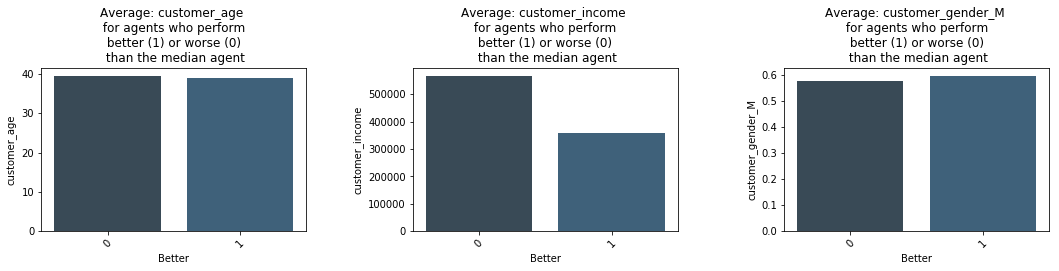

In [5]:
object_cols = ['customer_age', 'customer_income', 'customer_gender_M']

problem.plot_mean_agent_variables(agent_data, object_cols)

##### Visualize the product caracteristics by agent performance 
Next we vizualize the product caracteristics by agent performance

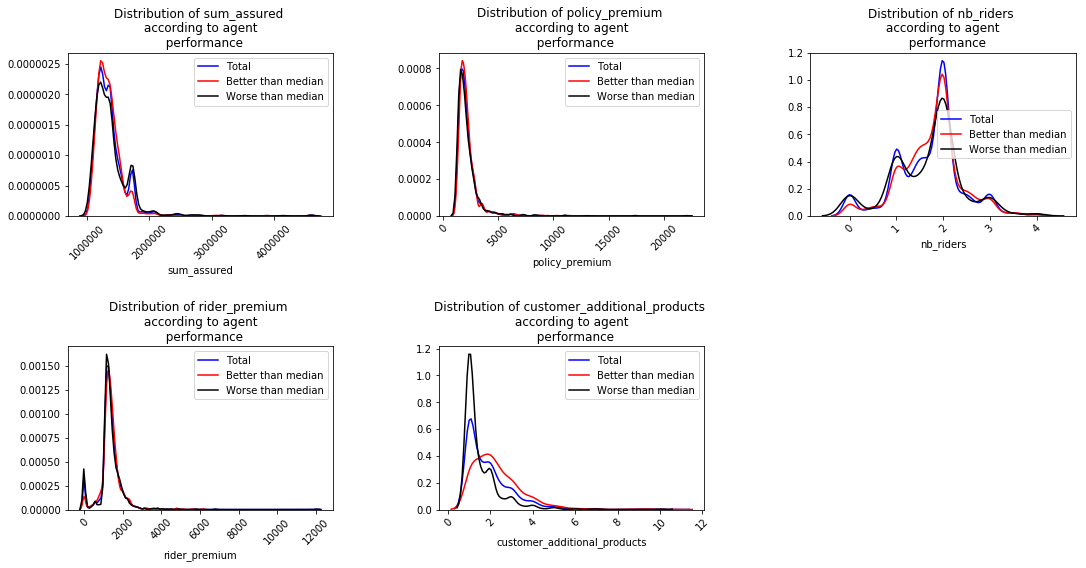

In [6]:
# Define cols about the agent
object_cols = ['sum_assured', 'policy_premium', 'nb_riders', 'rider_premium', 'customer_additional_products']

problem.plot_distributions(agent_data, object_cols)

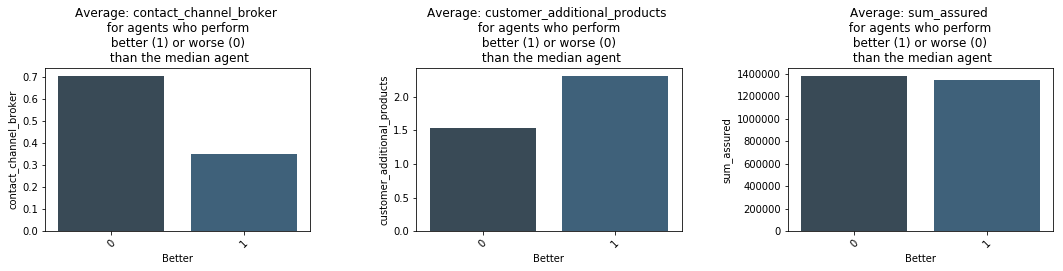

In [7]:
# And again categorical varibales are better plotted as barplots: 
object_cols = ['contact_channel_broker','customer_additional_products', 'sum_assured']

problem.plot_mean_agent_variables(agent_data, object_cols)

We see that agents who perform better seem to assure about the same sum and policy premium than worse performing agents on average. However, they seem to sell a higher number of additional products and a higher level of rider premium than worse performing agents. They also use less contact channel broker services. 

##### Visualize agent caracteristics

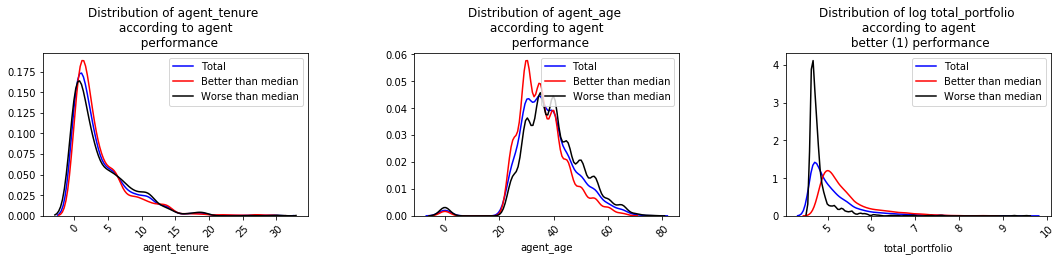

In [8]:
object_cols = ['agent_tenure', 'agent_age', 'total_portfolio']

problem.plot_distributions(agent_data, object_cols)

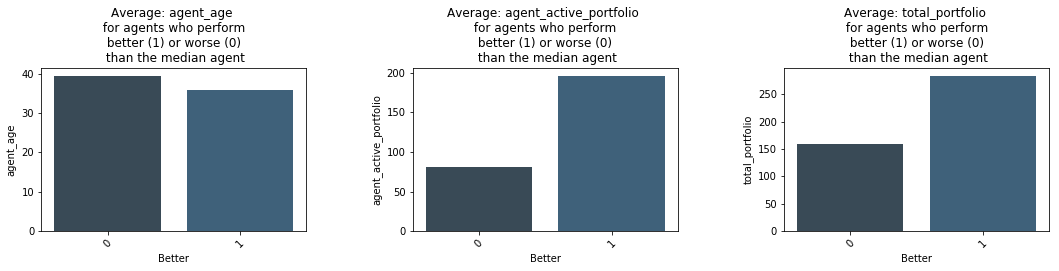

In [9]:
# And again categorical varibales are better plotted as barplots: 
object_cols = ['agent_age', 'agent_active_portfolio', 'total_portfolio',]

problem.plot_mean_agent_variables(agent_data, object_cols)

We see that the main difference between better and worse performing agent is the number of additional products they sell to clients and the number of total policies handled by the agent. Also, better performing agents seem to be slightly younger. 

## Create train.csv et test.csv <a class="anchor" id="first-bullet"></a> 

Now we construct a random forest model in order to predict whether an agent has a better or worse than median agent score. This is an attempt to better understand why better performing agents can achieve higher rate of client retention and once identified why their methods work better, the assurance company could urge all agents to follow similar strategies. 

In [10]:
# Drop variables 
agent_data = agent_data.drop(['agent_id', 'percent_of_active_portfolio', 'agent_active_portfolio', 
                              'agent_inactive_portfolio', 'total_portfolio', 'percent_of_portfolio', 
                             'Score', 'percent_of_active_portfolio'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(agent_data, agent_data['Better'], test_size=0.30, random_state=42)
X_train.to_csv("./data/train.csv", index=False)
X_test.to_csv("./data/test.csv", index=False)

## Create feature_extractor.py <a class="anchor" id="second-bullet"></a> 

In [11]:
# %load submissions/starting_kit/classifier.py
from __future__ import division
from sklearn.ensemble import RandomForestClassifier
from time import time
import pandas as pd
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
import os
from sklearn.tree import export_graphviz
import six
import pydot
from sklearn import tree



class Classifier():

    def __init__(self):
        self.model = RandomForestClassifier(criterion="entropy", n_estimators=101, random_state=47,
                                            max_depth=3, max_features=4)

    def fit(self, X, y, graph=False):
        print('Fitting model', end='...')
        start = time()
        self.model.fit(X, y)
        end = time()
        print('done')
        print('Training time took:', (end - start), 'sec')

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def plot_tree(self, data, y, i, num):
        cols = select_best_var(data, y, num, plot_=False)
        #dotfile = six.StringIO()
        estimator = self.model.estimators_[i]
        export_graphviz(estimator,
                        out_file='tree.dot',
                        filled=True,
                        rounded=True,
                        feature_names=cols,
                        class_names=['0', '1'])

        (graph,) = pydot.graph_from_dot_file('tree.dot')
        graph.write_png('tree.png')
        os.system('dot -Tpng tree.dot -o tree.png')
        return Image(filename='tree.png')


def select_best_var(data, y, num, plot_=True):
    importance = pd.DataFrame()
    importance['name'] = data.columns

    model = RandomForestClassifier(n_estimators=100)

    model.fit(data, y)
    importance['importance'] = model.feature_importances_

    if plot_:
        (pd.Series(model.feature_importances_, index=data.columns).nlargest(num).plot(kind='barh',
                                                                                      title='Feature importance of top features'))

    best_var = importance.sort_values(by=['importance'], ascending=False, inplace=False)
    best_var = best_var['name'][:num]
    best_var = best_var.values

    return best_var

## Create classifier.py <a class="anchor" id="third-bullet"></a> 

In [12]:
# %load submissions/starting_kit/feature_extractor.py

from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
import pandas as pd

class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.best_var = None
        pass

    def fit(self, X, y):
        self.best_var = select_best_var(X, y, 7)
        return self

    def transform(self, X):
        X = X[self.best_var]
        return X


def select_best_var(data, y, num, plot_=True):
    importance = pd.DataFrame()
    importance['name'] = data.columns

    model = RandomForestClassifier(n_estimators=100)

    model.fit(data, y)
    importance['importance'] = model.feature_importances_

    if plot_:
        (pd.Series(model.feature_importances_, index=data.columns).nlargest(num).plot(kind='barh',
                                                                                      title='Feature importance of top features'))

    best_var = importance.sort_values(by=['importance'], ascending=False, inplace=False)
    best_var = best_var['name'][:num]
    best_var = best_var.values

    return best_var

## Test Locally <a class="anchor" id="fourth-bullet"></a> 

Fitting model...done
Training time took: 0.17478585243225098 sec


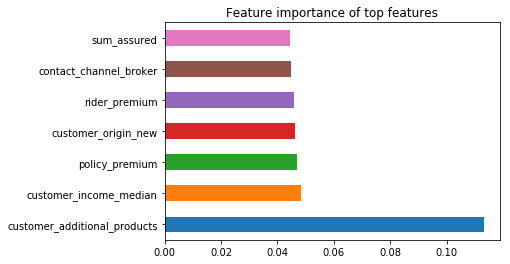

In [13]:
from sklearn.pipeline import Pipeline
X_train, X_test = X_train.drop('Better', axis=1), X_test.drop('Better', axis=1)

pipeline = Pipeline(steps=[('feature',FeatureExtractor()), ('classifier', Classifier())])
first_model = pipeline.fit(X_train, y_train)

In [14]:
try :
    model = first_model.named_steps['classifier']
    model.plot_tree(X_train, y_train, 100, 7)
except FileNotFoundError:
    print("File not found : you should have graphviz installed. \nIf it is not the case, you will miss the content of that cell")

File not found : you should have graphviz installed. 
If it is not the case, you will miss the content of that cell


In [15]:
y_pred = first_model.predict(X_test)

In [16]:
from sklearn.metrics import log_loss, classification_report

In [17]:
from sklearn.metrics import log_loss, classification_report

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.76      0.70      0.73       338
          1       0.71      0.77      0.74       325

avg / total       0.74      0.74      0.74       663



## Conclusion 

We see that those agent that sell additional products are more probable to have a higher than median score, in fact this feature is the first on the feature importance list, furthermore we can see that the feature 'contact channel broker' is the second most influential feature in predicting whether an agent has a lower or higher score than the median. We achieve an about 70% overall accuracy in predicting whether an agents score is better or worse than the median with a maximum tree depth of only 3 and only using a few features. 

**The conclusion of this part of the study is as follows:**
Firstly, better performing agents perform better not because of the clientele they have but because they seem to be better both in terms of the number of the total portfolios handled and the percentage of active portfolios. Better performing agents are slightly younger on average but the difference does not seem significant in terms of agent performance. 

Finally, both performance indicators that we use to construct the agent score is heavily dependent on the number of additional product an agent can sell. Those agents that are successfully advertise the additional products can secure clients better. We think that the reason is as follows: if a client has only one assurance contract with the company, and finds a cheaper opportunity elsewhere, will easily move to competitor. Those clients who have several insurance with the entreprise will lose the facility to treat each assurance with the same agent, a bit like a package deal. Therefore the most important conclusion of this study is that if the company wishes to have a clientele that stays for long term with the company, they should try to offer clients several insurance (package deals or reductions for already existing clients) and try to use less contact by channel brokers. 

Also, initially we thought that agents who have fewer clients might be better in retaining their clients as they can spend more time on them. However, we find that the assurance company should not limit the number of clients an agent can have, since agents who handled many clients seem to be better performing. 

## Test with Ramp <a class="anchor" id="fifth-bullet"></a> 

In [18]:
!ramp_test_submission --quick-test

Testing Individual agent performance
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
CV fold 0
Fitting model...done
Training time took: 0.09636521339416504 sec
	score  weighted_fscore  recall  precision
	train             0.79    0.79       0.81
	valid             0.77    0.79       0.68
	test              0.71    0.72       0.68
CV fold 1
Fitting model...done
Training time took: 0.09141039848327637 sec
	score  weighted_fscore  recall  precision
	train             0.83    0.83       0.86
	valid             0.80    0.83       0.68
	test              0.74    0.75       0.69
CV fold 2
Fitting model...done
Training time took: 0.09686541557312012 sec
	score  weighted_fscore  recall  precision
	train             0.83    0.83       0.81
	valid             0.62    0.61       0.67
	test              0.70    0.70       0.68
CV fold 3
Fitting model...done
Training time took: 0.09297680854797363 sec
	score  weighted_fscore  recall  precision
	tra